In [177]:
import geojson
import pandas as pd
import shapely
from matplotlib import pyplot as plt
from matplotlib.path import Path
import numpy as np
from scipy.ndimage import distance_transform_edt as dt

In [178]:
sample = 'IPICRC072'

cell_table_filepath = "/media/austin/DrosophilaMelanogaster/IPI/8plex/analysis/"+sample+"/cell_table_arcsinh_transformed_stitched.csv"
qupath_annotation_filepath = "/media/austin/DrosophilaMelanogaster/IPI/8plex/analysis/tumor_annotations/"+sample+"_epcam_annotations.json"
save_filepath = "/media/austin/DrosophilaMelanogaster/IPI/8plex/analysis/"+sample+"/cell_table_arcsinh_transformed_stitched_gated_tumorannotated.csv"

um_ppix = 0.325

tile_metadata = "/media/austin/DrosophilaMelanogaster/IPI/8plex/analysis/"+sample+"/tile_metadata.txt"

In [179]:
df = pd.read_csv(cell_table_filepath)

tile_pos_data = pd.read_csv(tile_metadata,header=None)
tile_pos_data = tile_pos_data.rename(columns={0:"fov",1:"x1",2:"x2",3:"y1",4:"y2"})

In [180]:
y = np.array(df['centroid-0'].values, dtype=np.int16)
x = np.array(df['centroid-1'].values, dtype=np.int16)
pos = np.vstack((x,y)).transpose()

#lbl = np.array(["in_tumor_boundary"]*pos.shape[0])
lbl = np.array(np.zeros(pos.shape[0]), dtype=np.int32)



In [181]:
with open(qupath_annotation_filepath,"r") as f:
    data = geojson.load(f)

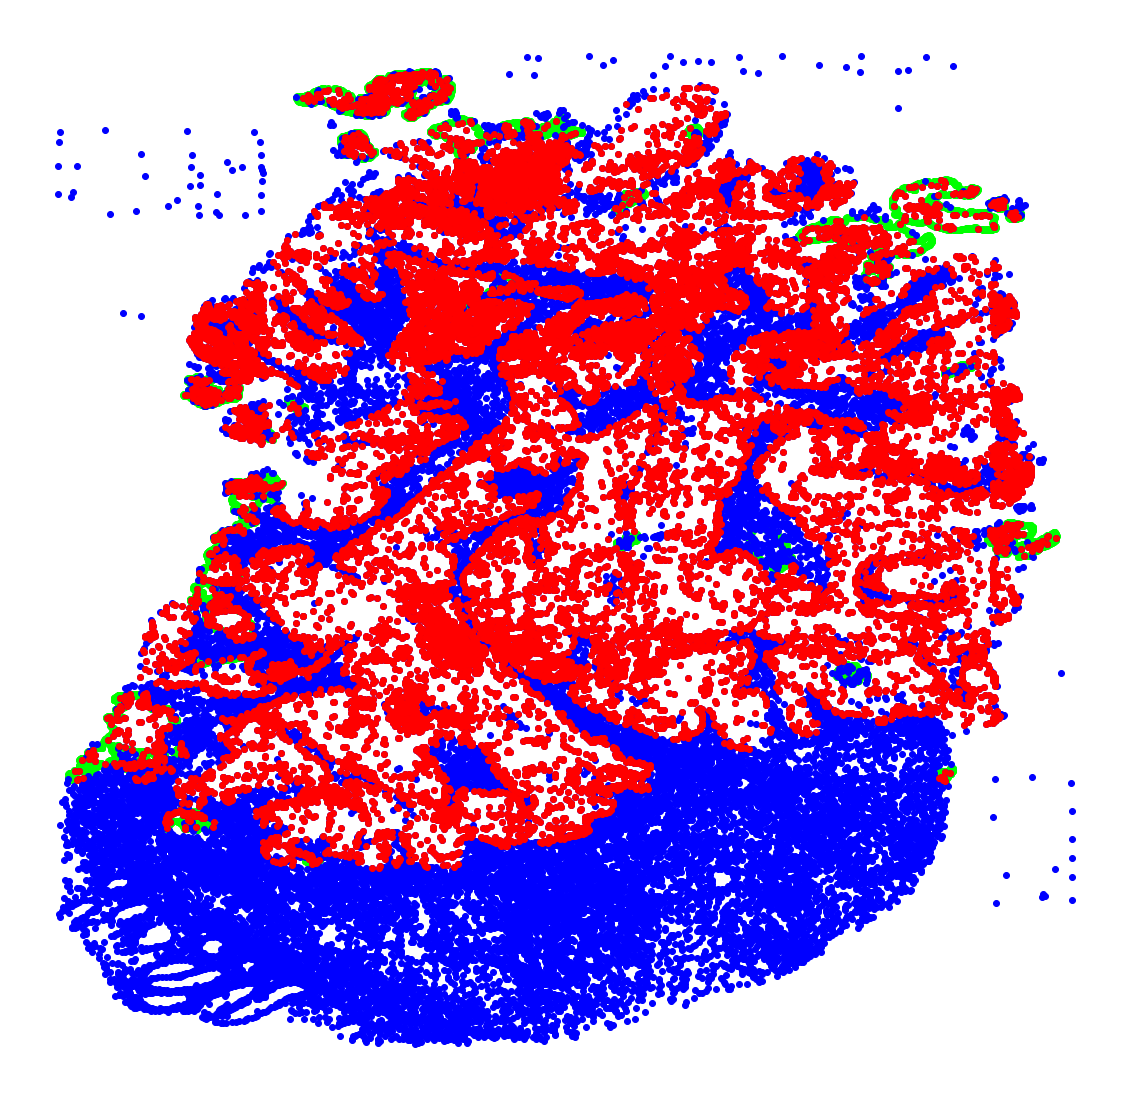

In [182]:
plot = True
if plot: 
    plt.figure(figsize=(20,20))
    #fig, ax = plt.subplots(1)

# binary image for distance transform
image = np.ones((int(tile_pos_data['y2'].max()), int(tile_pos_data['x2'].max())))
    
for i, obj in enumerate(data):

    coord_list = obj['geometry']['coordinates']
        
    coords = np.array(coord_list[0])
    p = Path(coords)
    tf = p.contains_points(pos)

    lbl[tf] = 1

    image[coords[:,0],coords[:,1]] = 0
        
    if len(coord_list) > 1:
        
        for holes in coord_list[1:]:
            coords = np.array(holes)
            p = Path(coords)
            tf = p.contains_points(pos)
            
            lbl[tf] = 0
            
            image[coords[:,0],coords[:,1]] = 0

    
    if plot:
        plt.scatter(p.vertices[:,0], p.vertices[:,1], color=[0,1,0])
    
    
    
if plot:
    plt.scatter(x,y,color=[0,0,1])
    idx = lbl==1
    plt.scatter(pos[idx,0],pos[idx,1],color=[1,0,0])
    plt.axis('off')
    #plt.invert_yaxis()    
    plt.show()

In [183]:
# distance transform and then convert to microns
distance_image = dt(image)*um_ppix

<Figure size 1440x1440 with 0 Axes>

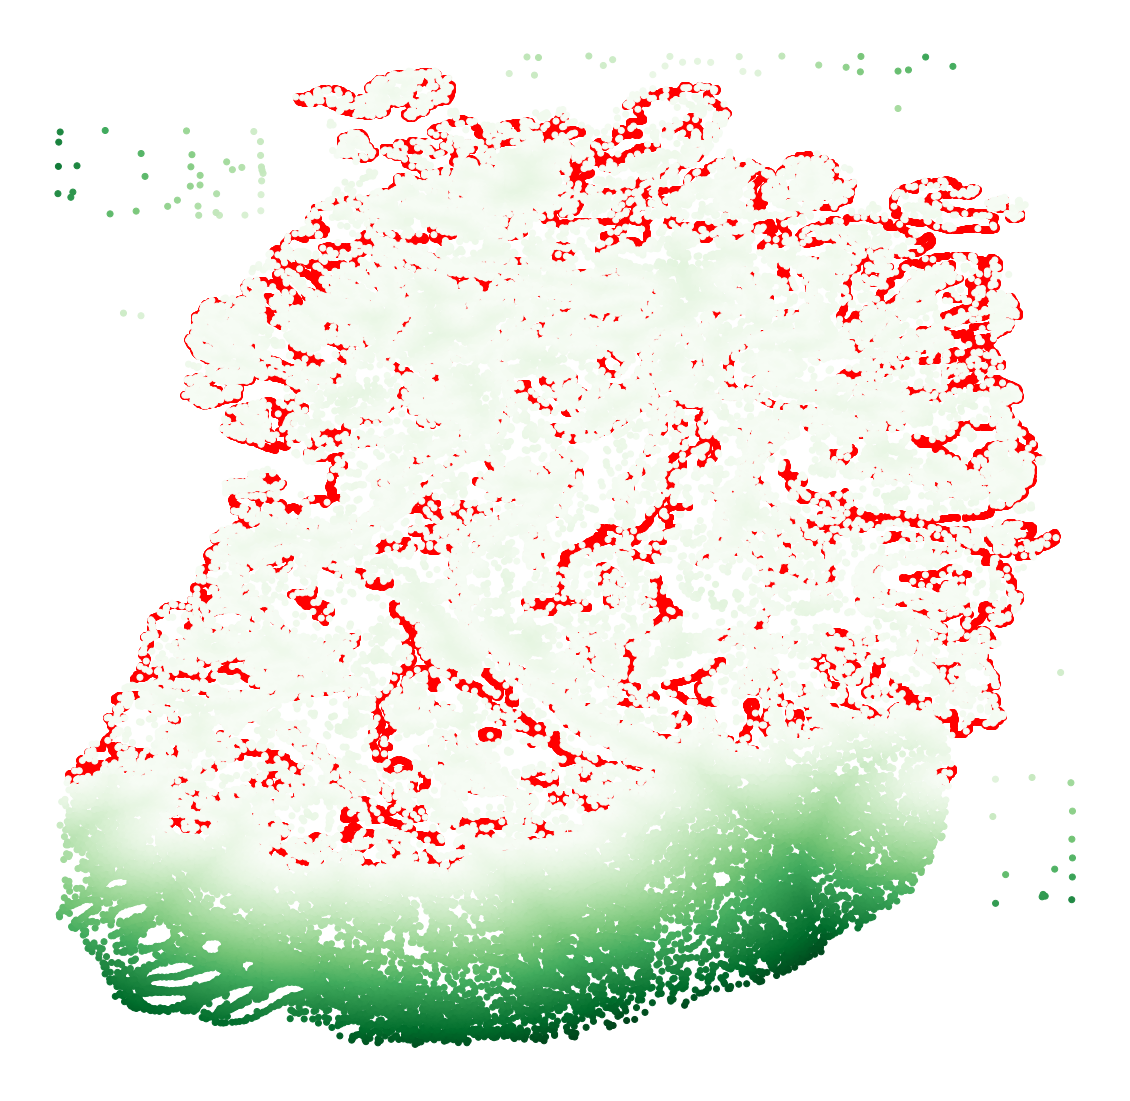

In [197]:


f = plt.figure(figsize=(20,20))

plot = True
if plot: 
    plt.figure(figsize=(20,20))
    #fig, ax = plt.subplots(1)

# binary image for distance transform
image = np.ones((int(tile_pos_data['y2'].max()), int(tile_pos_data['x2'].max())))
    
for i, obj in enumerate(data):

    coord_list = obj['geometry']['coordinates']
        
    coords = np.array(coord_list[0])
    p = Path(coords)
    
    plt.scatter(p.vertices[:,0], p.vertices[:,1], color=[1,0,0])
        
    if len(coord_list) > 1:
        
        for holes in coord_list[1:]:
            coords = np.array(holes)
            p = Path(coords)
    
    
            plt.scatter(p.vertices[:,0], p.vertices[:,1], color=[1,0,0])
    


plt.scatter(x,y,c=distances,cmap='Greens')
plt.axis('off')
plt.show()


In [185]:
distances = distance_image[x,y]

In [163]:
distances = distance_image[x,y]
df['in_tumor'] = lbl
df['dist_tumor_boundary_um'] = distances

df.to_csv(save_filepath)

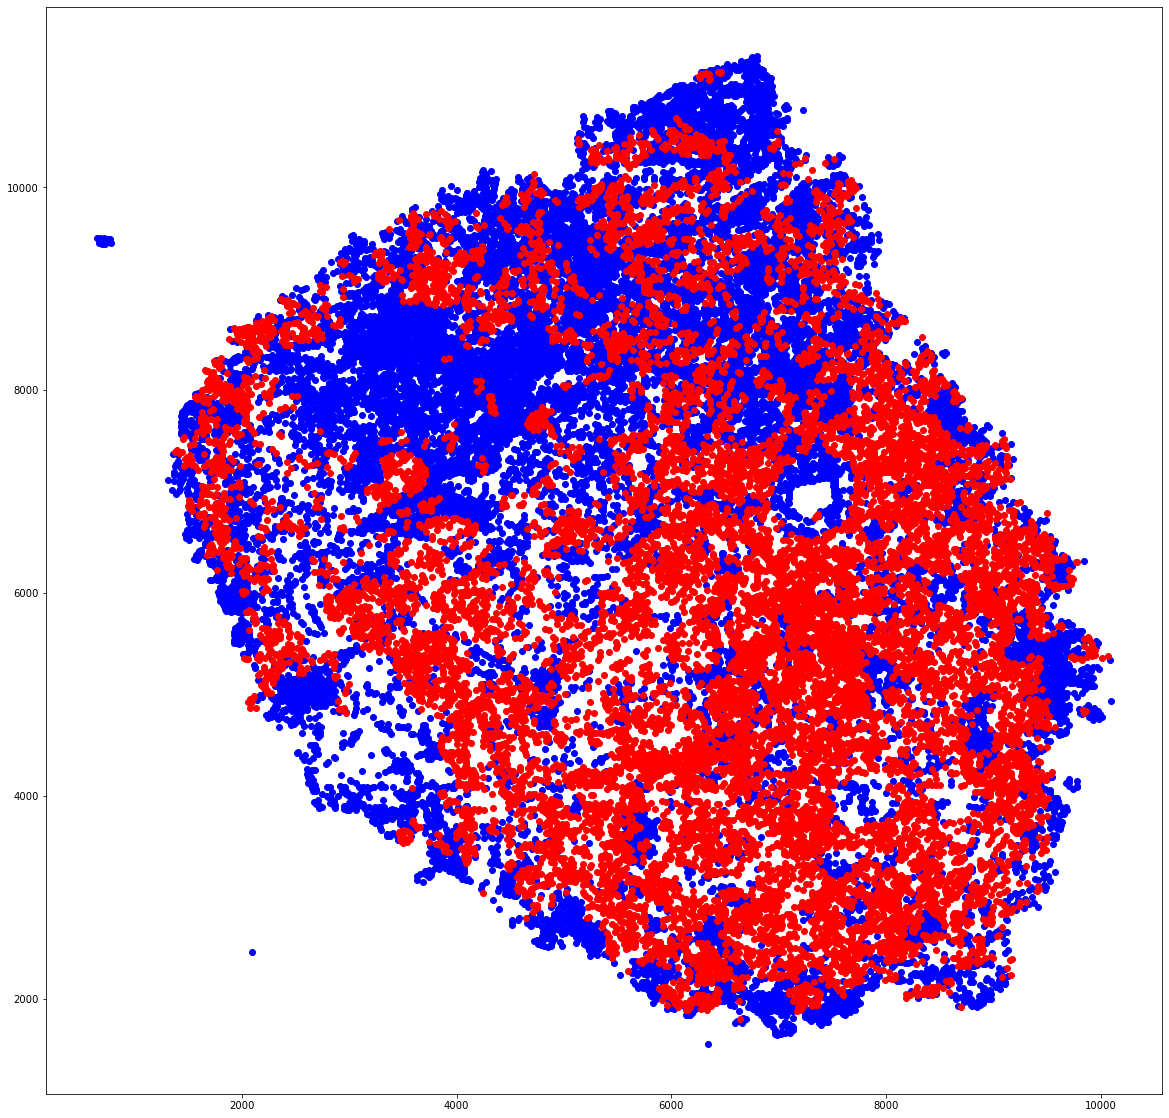